In [1]:
import pathlib, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# project paths (notebook is in notebooks/)
BASE = pathlib.Path.cwd().parents[0]
DATA_INTERIM = BASE / "data" / "interim"
DATA_PROCESSED = BASE / "data" / "processed"
REPORTS = BASE / "reports"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

# edit this list if you ingested different tickers
SYMBOLS = ["QQQ", "VFV.TO", "XEQT.TO"]

print("interim:", DATA_INTERIM)
print("processed:", DATA_PROCESSED)
print("reports:", REPORTS)

interim: /Users/itzronald/Desktop/trend-predictor/data/interim
processed: /Users/itzronald/Desktop/trend-predictor/data/processed
reports: /Users/itzronald/Desktop/trend-predictor/reports


In [2]:
#install dependencies for Parquet
%pip install --quiet pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [3]:
def load_csv(symbol: str) -> pd.DataFrame:
    """Read Day-1 CSV, enforce column order, sort by date."""
    path = DATA_INTERIM / f"{symbol}.csv"
    df = pd.read_csv(path, parse_dates=["date"])
    expected = ["date","open","high","low","close","adj_close","volume"]
    # tolerate missing columns by creating placeholders if needed
    for c in expected:
        if c not in df.columns:
            df[c] = np.nan
    df = df[expected].sort_values("date").reset_index(drop=True)
    return df

# quick peek
for s in SYMBOLS:
    df = load_csv(s)
    print(s, df.shape, "columns:", list(df.columns))
    display(df.head(3))

QQQ (6493, 7) columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


,date,open,high,low,close,adj_close,volume
0,1999-11-01,131.5,133.1,130.6,130.8,130.8,4840900
1,1999-11-02,131.5,133.1,130.4,130.9,130.9,6417400
2,1999-11-03,132.8,134.3,132.4,133.5,133.5,9376300


VFV.TO (3210, 7) columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


,date,open,high,low,close,adj_close,volume
0,2012-11-08,24.73,24.73,24.69,24.69,24.69,4400
1,2012-11-09,24.50,24.69,24.49,24.60,24.60,2900
2,2012-11-12,24.60,24.60,24.57,24.57,24.57,1200


XEQT.TO (1514, 7) columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


,date,open,high,low,close,adj_close,volume
0,2019-08-14,20.1107,20.1107,19.8642,19.8642,19.8642,1988
1,2019-08-15,19.8642,19.8642,19.8642,19.8642,19.8642,0
2,2019-08-16,20.0805,20.0805,20.0805,20.0805,20.0805,596


In [4]:
def coerce_and_check(df: pd.DataFrame, symbol: str) -> pd.DataFrame:
    # 1) numeric types
    num_cols = ["open","high","low","close","adj_close","volume"]
    for c in num_cols:
        if c == "volume":
            df[c] = pd.to_numeric(df[c], errors="coerce")
            # volumes should be non-negative integers; set negatives to NaN first
            df.loc[df[c] < 0, c] = np.nan
            df[c] = df[c].fillna(0).astype("int64")
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 2) drop rows with missing essential prices
    df = df.dropna(subset=["open","high","low","close"])

    # 3) sanity: OHLC relationships
    #    remove rows where high < low (data error)
    df = df[df["high"] >= df["low"]]

    # 4) deduplicate dates (keep the last if duplicates exist)
    df = df.drop_duplicates(subset=["date"], keep="last")

    # 5) ensure strictly increasing dates
    df = df.sort_values("date").reset_index(drop=True)

    # 6) set adj_close = close for now (free API endpoint, no adj_close available)
    df["adj_close"] = df["close"]

    #    no forward-fill
    #    Because holidays/closures are real; we don't create artificial rows.

    # small QA report
    msg = (
        f"{symbol}: rows={len(df)}, "
        f"date_range=[{df['date'].min().date()} → {df['date'].max().date()}], "
        f"nulls(open..adj_close..volume)={[df[c].isna().sum() for c in ['open','high','low','close','adj_close','volume']]}"
    )
    print(msg)
    return df

# run coercion on each symbol and keep a dict in memory
cleaned = {}
for s in SYMBOLS:
    cleaned[s] = coerce_and_check(load_csv(s), s)

QQQ: rows=6493, date_range=[1999-11-01 → 2025-08-25], nulls(open..adj_close..volume)=[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
VFV.TO: rows=3210, date_range=[2012-11-08 → 2025-08-25], nulls(open..adj_close..volume)=[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
XEQT.TO: rows=1514, date_range=[2019-08-14 → 2025-08-25], nulls(open..adj_close..volume)=[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


In [5]:
def save_parquet(df: pd.DataFrame, symbol: str) -> pathlib.Path:
    outp = DATA_PROCESSED / f"{symbol}.parquet"
    df.to_parquet(outp, index=False)  # uses pyarrow/fastparquet
    return outp

summary = []
for s, df in cleaned.items():
    outp = save_parquet(df, s)
    summary.append((s, len(df), outp.name))

pd.DataFrame(summary, columns=["symbol","rows","parquet_file"])

,symbol,rows,parquet_file
0,QQQ,6493,QQQ.parquet
1,VFV.TO,3210,VFV.TO.parquet
2,XEQT.TO,1514,XEQT.TO.parquet


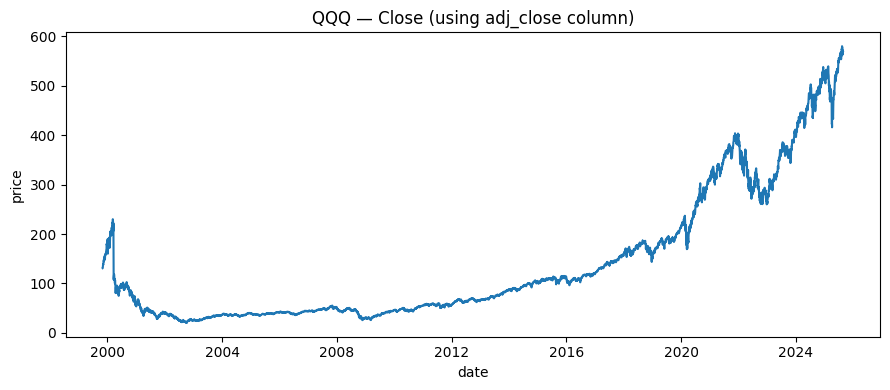

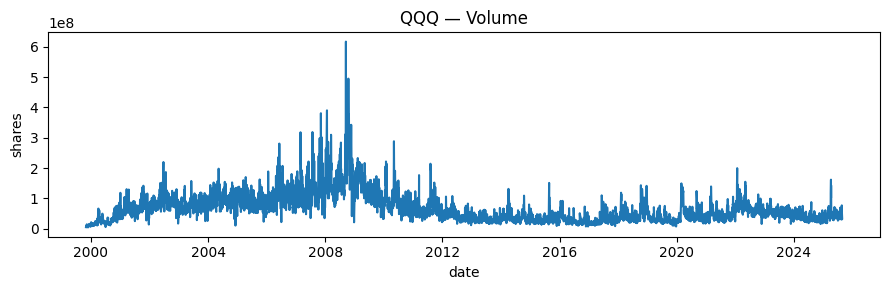

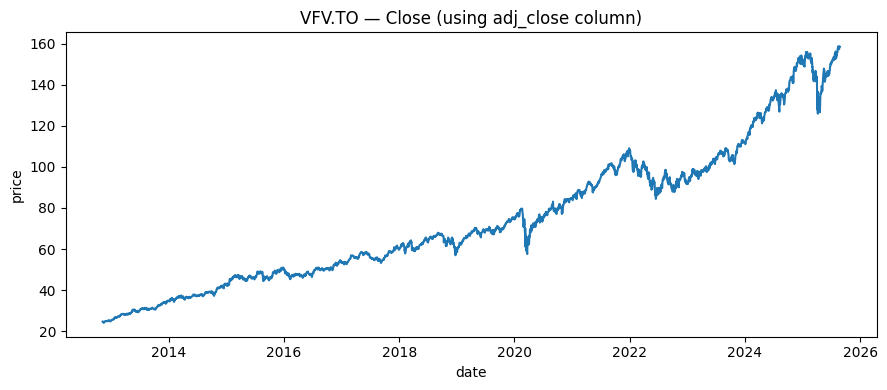

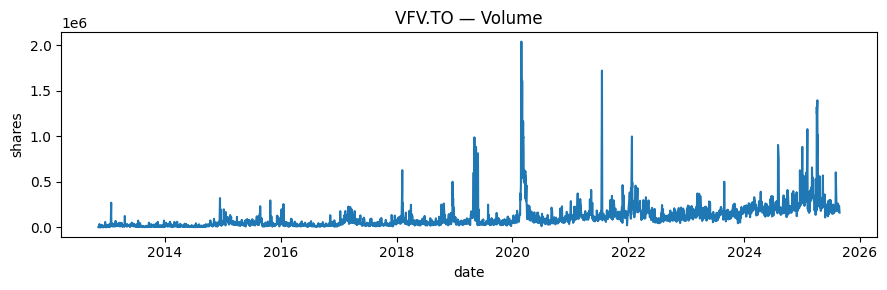

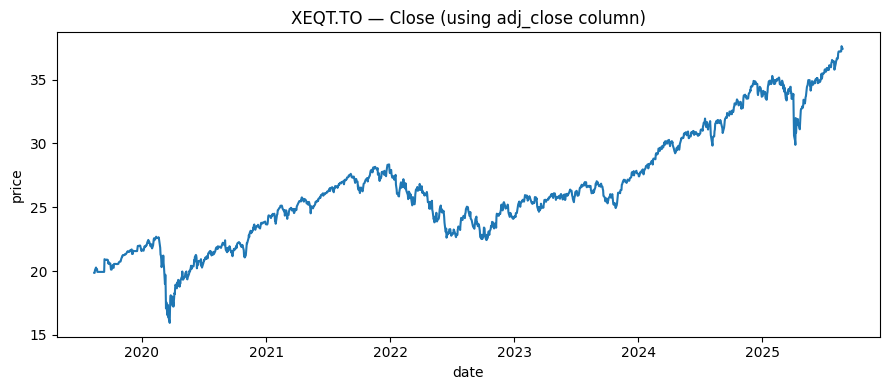

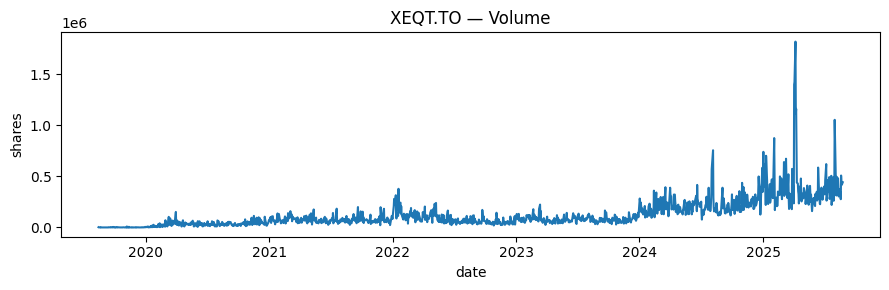

In [6]:
def plot_symbol(df: pd.DataFrame, symbol: str):
    # price
    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(df["date"], df["adj_close"])
    ax.set_title(f"{symbol} — Close (using adj_close column)")
    ax.set_xlabel("date"); ax.set_ylabel("price")
    fig.tight_layout()
    fig.savefig(REPORTS / f"{symbol}_price.png", dpi=150)
    plt.show()

    # volume
    fig, ax = plt.subplots(figsize=(9,3))
    ax.plot(df["date"], df["volume"])
    ax.set_title(f"{symbol} — Volume")
    ax.set_xlabel("date"); ax.set_ylabel("shares")
    fig.tight_layout()
    fig.savefig(REPORTS / f"{symbol}_volume.png", dpi=150)
    plt.show()

for s in SYMBOLS:
    df = pd.read_parquet(DATA_PROCESSED / f"{s}.parquet")
    plot_symbol(df, s)

In [7]:
#Additional Checks to make sure everything is working
from pathlib import Path

# Parquet existence + file size
for s in SYMBOLS:
    p = DATA_PROCESSED / f"{s}.parquet"
    print(s, "exists:", p.exists(), "size:", p.stat().st_size if p.exists() else None)

# Plot images existence
for s in SYMBOLS:
    ok_price = (REPORTS / f"{s}_price.png").exists()
    ok_vol   = (REPORTS / f"{s}_volume.png").exists()
    print(s, "plots:", ok_price and ok_vol, "| price:", ok_price, "| volume:", ok_vol)

QQQ exists: True size: 284340
VFV.TO exists: True size: 127949
XEQT.TO exists: True size: 71168
QQQ plots: True | price: True | volume: True
VFV.TO plots: True | price: True | volume: True
XEQT.TO plots: True | price: True | volume: True


In [8]:
#QA Checks
for s, df in cleaned.items():
    assert df["date"].is_monotonic_increasing, f"{s}: dates not increasing"
    assert (df["high"] >= df["low"]).all(), f"{s}: found high < low rows"
    assert df[["open","high","low","close","adj_close"]].isna().sum().sum() == 0, f"{s}: NaNs in price fields"
print("QA assertions passed ✅")

QA assertions passed ✅
